# Load pickle file with pred and targets

In [1]:

import pickle
import numpy as np
import os
import sklearn
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define path to your pickle file where targets and predictions are stored
pickle_file_test = "/home/projects/vokquant/accent-recog-slt2022/CommonAccent/results/W2V2/AT/wav2vec2-large-xlsr-53-augmented/7001/save/predictions/test_predictions.pkl"
# pickle_file_val = "/home/projects/vokquant/accent-recog-slt2022/CommonAccent/results/W2V2/AT/wav2vec2-large-xlsr-53-augmented/7001/save/predictions/val_predictions.pkl"

# set:
pickle_file = pickle_file_test

combined_batch_ids = []
combined_predictions = []
combined_targets = []
combined_lens = []

# Open file and read all objects (batches). Otherwise only last batch is loaded
with open(pickle_file, "rb") as f:
    while True:
        try:
            batch = pickle.load(f)
            # Append data for each batch
            combined_batch_ids.extend(batch["batch_ids"])
            combined_predictions.append(batch["predictions"])
            combined_targets.append(batch["targets"])
            combined_lens.append(batch["lens"])
        except EOFError:
            break

# Concatenate predictions, targets, and lens across all batches
combined_predictions = np.concatenate(combined_predictions, axis=0)
combined_targets = np.concatenate(combined_targets, axis=0)
combined_lens = np.concatenate(combined_lens, axis=0)

print("len predictions: ", len(combined_predictions))
print("len targets: ", len(combined_targets))

len predictions:  5728
len targets:  5728


# Load accent_encoder file and create dict

In [2]:
accent_encoder = '/home/projects/vokquant/accent-recog-slt2022/CommonAccent/results/W2V2/AT/wav2vec2-large-xlsr-53-augmented/7001/save/accent_encoder.txt'
with open(accent_encoder, 'r') as f:
    accent_encoder = f.read().splitlines()

encoder_dict = {}
for line in accent_encoder[:-2]:
    region, encoding = line.split(' => ')
    # print(region, encoding)
    encoder_dict[encoding] = int(region.strip().strip("'"))
print(encoder_dict)

# ALTERNATIVE:  just type the class mapping:
# class_mapping = {
# '62390': 0, '70221': 1, '30860': 2, '31035': 3, '50413': 4, '41706': 5, '70709': 6, '80105': 7, '40719': 8, '70334': 9, '70406': 10, '31405': 11, '32210': 12, '70627': 13, '50304': 14, '70706': 15, '31207': 16, '40702': 17, '40423': 18, '40410': 19, '32309': 20, '41411': 21, '10702': 22, '70208': 23, '70734': 24, '50626': 25, '80225': 26, '30501': 27, '70622': 28, '40621': 29, '50621': 30, '62216': 31, '41342': 32, '61032': 33, '30910': 34, '10903': 35, '50617': 36, '31110': 37, '70615': 38, '20622': 39, '20914': 40, '80411': 41, '50612': 42, '50502': 43, '61627': 44, '32324': 45, '70516': 46, '10925': 47, '40806': 48, '80239': 49, '20321': 50, '80227': 51, '70804': 52, '80128': 53, '41804': 54, '31652': 55, '61257': 56, '30719': 57, '60350': 58, '50509': 59, '70402': 60, '20619': 61, '10401': 62, '61628': 63, '70824': 64, '70606': 65, '50206': 66, '61254': 67, '62105': 68, '31916': 69, '50210': 70, '40402': 71, '61115': 72, '70908': 73, '70419': 74, '70366': 75, '61743': 76, '32518': 77, '40914': 78, '31617': 79, '31401': 80, '50212': 81, '80212': 82, '41501': 83, '70326': 84, '40605': 85, '70362': 86, '70217': 87, '62144': 88, '10428': 89, '32519': 90, '10612': 91, '41102': 92, '50618': 93, '32002': 94, '50506': 95, '21002': 96, '62135': 97, '20604': 98, '61251': 99, '50423': 100, '31814': 101, '70825': 102, '31551': 103, '80109': 104, '31204': 105, '61756': 106, '70920': 107, '70504': 108
# }

{'0': 62390, '1': 70221, '2': 30860, '3': 31035, '4': 50413, '5': 41706, '6': 70709, '7': 80105, '8': 40719, '9': 70334, '10': 70406, '11': 31405, '12': 32210, '13': 70627, '14': 50304, '15': 70706, '16': 31207, '17': 40702, '18': 40423, '19': 40410, '20': 32309, '21': 41411, '22': 10702, '23': 70208, '24': 70734, '25': 50626, '26': 80225, '27': 30501, '28': 70622, '29': 40621, '30': 50621, '31': 62216, '32': 41342, '33': 61032, '34': 30910, '35': 10903, '36': 50617, '37': 31110, '38': 70615, '39': 20622, '40': 20914, '41': 80411, '42': 50612, '43': 50502, '44': 61627, '45': 32324, '46': 70516, '47': 10925, '48': 40806, '49': 80239, '50': 20321, '51': 80227, '52': 70804, '53': 80128, '54': 41804, '55': 31652, '56': 61257, '57': 30719, '58': 60350, '59': 50509, '60': 70402, '61': 20619, '62': 10401, '63': 61628, '64': 70824, '65': 70606, '66': 50206, '67': 61254, '68': 62105, '69': 31916, '70': 50210, '71': 40402, '72': 61115, '73': 70908, '74': 70419, '75': 70366, '76': 61743, '77': 32

# Connect encoder ids with labels

In [3]:
# get max value of the prediction
combined_predictions_max = np.argmax(combined_predictions, axis=1)
#convert combined_predictions_max and targets to accent
combined_predictions_accent = []
for i in combined_predictions_max:
    combined_predictions_accent.append(encoder_dict[str(i)])

combined_targets_accent = []
for i in combined_targets:
    combined_targets_accent.append(encoder_dict[str(i)])


# Use "Bundesländer" as regions

In [4]:
region_dict = {}
mapping_regions_dict = {'1': 'bgld', '2': 'ktn', '3': 'noe',
                        '4': 'ooe', '5': 'sbg', '6': 'stmk',
                        '7': 't', '8': 'vbg'}   #, '9': 'w'}

unique_accent = set(combined_predictions_accent)    #get unique accents
for i in unique_accent:
    for j in range(1, len(mapping_regions_dict)+1):  # make loop from 1 to 8 (or 9)
        if str(i)[0] == str(j):
            region_dict[i] = mapping_regions_dict[str(j)]

# map combined_predictions_accent and combined_targets_accent to region
combined_predictions_region = []
for i in combined_predictions_accent:
    combined_predictions_region.append(region_dict[i])
combined_targets_region = []
for i in combined_targets_accent:
    combined_targets_region.append(region_dict[i])

# Use "Dialektfamilien"

Accuracy (Dialektfamilie):  0.5605796089385475
F1 score (Dialektfamilie):  0.5836602584741121


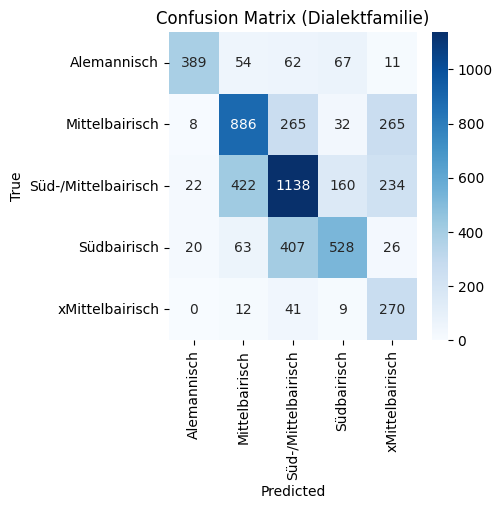

In [5]:
file_path = '/home/projects/vokquant/data/dicla/DiÖ_PP02_Korpus_Dokumentation_final_Dialaketfamilie.xlsx'
df = pd.read_excel(file_path)

folder_list = os.listdir('/home/projects/vokquant/data/dicla/augmented/')
mapping_family_dict = dict(zip(df['Gemeindekennziffer'], df['Dialektfamilie']))
# remove nan
city_code_dict = {k: v for k, v in mapping_family_dict.items() if pd.notna(v)}

# map  combined_predictions_accent and combined_targets_accent to Dialektfamilie
combined_predictions_family = []
for i in combined_predictions_accent:
    combined_predictions_family.append(mapping_family_dict[i])
    
combined_targets_family = []
for i in combined_targets_accent:
    combined_targets_family.append(mapping_family_dict[i])

# Accuracy and F1 score
correct = 0
total = 0
for i in range(len(combined_predictions_family)):
    if combined_predictions_family[i] == combined_targets_family[i]:
        correct += 1
    total += 1
print("Accuracy (Dialektfamilie): ", correct/total)

f1 = f1_score(combined_targets_family, combined_predictions_family, average='weighted')
print("F1 score (Dialektfamilie): ", f1)

unique_values = np.unique(combined_targets_family)

# confusion_matrix
confusion_matrix = sklearn.metrics.confusion_matrix(combined_targets_family, combined_predictions_family, labels=unique_values)

# add labels to confusion matrix
confusion_matrix = pd.DataFrame(confusion_matrix, index=unique_values, columns=unique_values)

# plot confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Dialektfamilie)')
plt.show()

Accuracy (Dialektfamilie):  0.6089385474860335
F1 score (Dialektfamilie):  0.6229452432141397


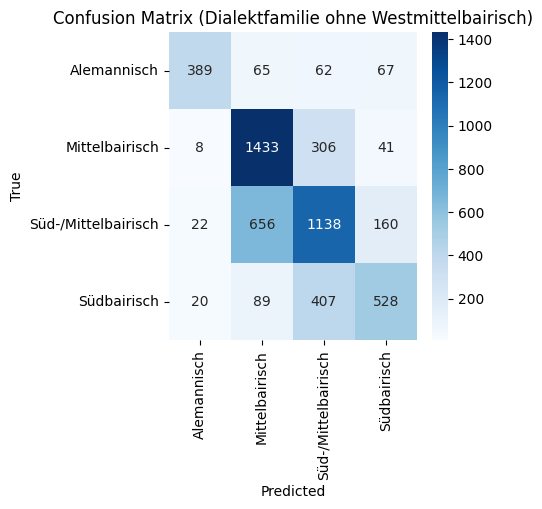

In [6]:
# now put xMittelbairisch and Mittelbairisch together
combined_targets_family_together = []
for i in combined_targets_family:
    if i == 'Mittelbairisch' or i == 'xMittelbairisch':
        combined_targets_family_together.append('Mittelbairisch')
    else:
        combined_targets_family_together.append(i)

combined_predictions_family_together = []
for i in combined_predictions_family:
    if i == 'Mittelbairisch' or i == 'xMittelbairisch':
        combined_predictions_family_together.append('Mittelbairisch')
    else:
        combined_predictions_family_together.append(i)
        
# accuracy and F1 score
correct = 0
total = 0
for i in range(len(combined_predictions_family_together)):
    if combined_predictions_family_together[i] == combined_targets_family_together[i]:
        correct += 1
    total += 1
print("Accuracy (Dialektfamilie): ", correct/total)

f1 = f1_score(combined_targets_family_together, combined_predictions_family_together, average='weighted')
print("F1 score (Dialektfamilie): ", f1)

unique_values_together = np.unique(combined_targets_family_together)

# confusion_matrix
confusion_matrix = sklearn.metrics.confusion_matrix(combined_targets_family_together, combined_predictions_family_together, labels=unique_values_together)

# add labels to confusion matrix
confusion_matrix = pd.DataFrame(confusion_matrix, index=unique_values_together, columns=unique_values_together)

# plot confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Dialektfamilie ohne Westmittelbairisch)')
plt.show()
# save picture




# Calculate Statistics

Accuracy per accent:  0.03
F1 score per accent:  0.052
Accuracy per Bundesland:  0.393
F1 score per Bundesland:  0.387


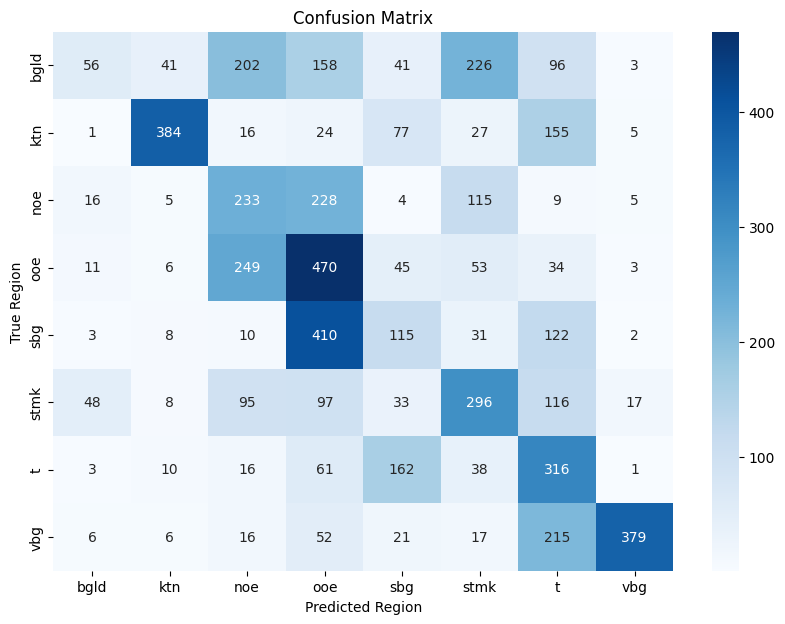

In [7]:
# calculate per accent
correct = 0
for i in range(len(combined_predictions_accent)):
    if combined_predictions_accent[i] == combined_targets_accent[i]:
        correct += 1
accuracy_region = correct/len(combined_predictions_accent)
f1_region = f1_score(combined_targets_accent, combined_predictions_accent, average='weighted')
#{'micro', 'weighted', 'binary', 'samples', 'macro'}
print("Accuracy per accent: ", np.round(accuracy_region, 3))
print("F1 score per accent: ", np.round(f1_region, 3))

# calculate accuracy
correct = 0
for i in range(len(combined_predictions_region)):
    if combined_predictions_region[i] == combined_targets_region[i]:
        correct += 1
accuracy = correct/len(combined_predictions_region)
print("Accuracy per Bundesland: ", np.round(accuracy, 3))

f1 = f1_score(combined_targets_region, combined_predictions_region, average='weighted')
print("F1 score per Bundesland: ", np.round(f1, 3))
confusion_matrix = sklearn.metrics.confusion_matrix(combined_targets_region, combined_predictions_region)

# Add labels to confusion matrix
df_cm = pd.DataFrame(confusion_matrix, index=[i for i in mapping_regions_dict.values()],
                     columns=[i for i in mapping_regions_dict.values()])

plt.figure(figsize=(10,7))

# Use `fmt='d'` in the heatmap to display the annotations as integers instead of scientific notation
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')

# Plot titles and labels
plt.xlabel('Predicted Region')
plt.ylabel('True Region')
plt.title('Confusion Matrix')

# Display the heatmap
plt.show()

In [8]:
# DO NOT RUN
# This is the conf matrix for Validation set: